# Exploratory Data Analysis

The dataset can be found here: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud

It is given as 27 principal components of a fraud credit card transaction dataset, so the original features (e.g. location, merchant type) have been transformed via PCA to anonymise sensitive information. This means we are working in a lower-dimensional feature space where each principal component (PC) is a linear combination of the original features, and they are ordered by the amount of variance they explain in the data.

Despite the lack of original feature names, we can still perform meaningful EDA to understand:

- The distribution of each principal component
- How each component differs between fraudulent (`Class = 1`) and non-fraudulent (`Class = 0`) transactions
- Whether any PCs are particularly discriminative for fraud detection
- Outliers or skewed distributions that may affect model performance

We'll start by checking the class balance, followed by distribution plots (histograms, boxplots, KDEs) for each PC, grouped by class label. Since the classes are highly imbalanced in this dataset, we will also explore how this imbalance might influence our visual interpretations and later modeling decisions.


In [1]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
os.chdir('/app')

In [2]:
df = pd.read_csv('data/raw/creditcard.csv')

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.Class.value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

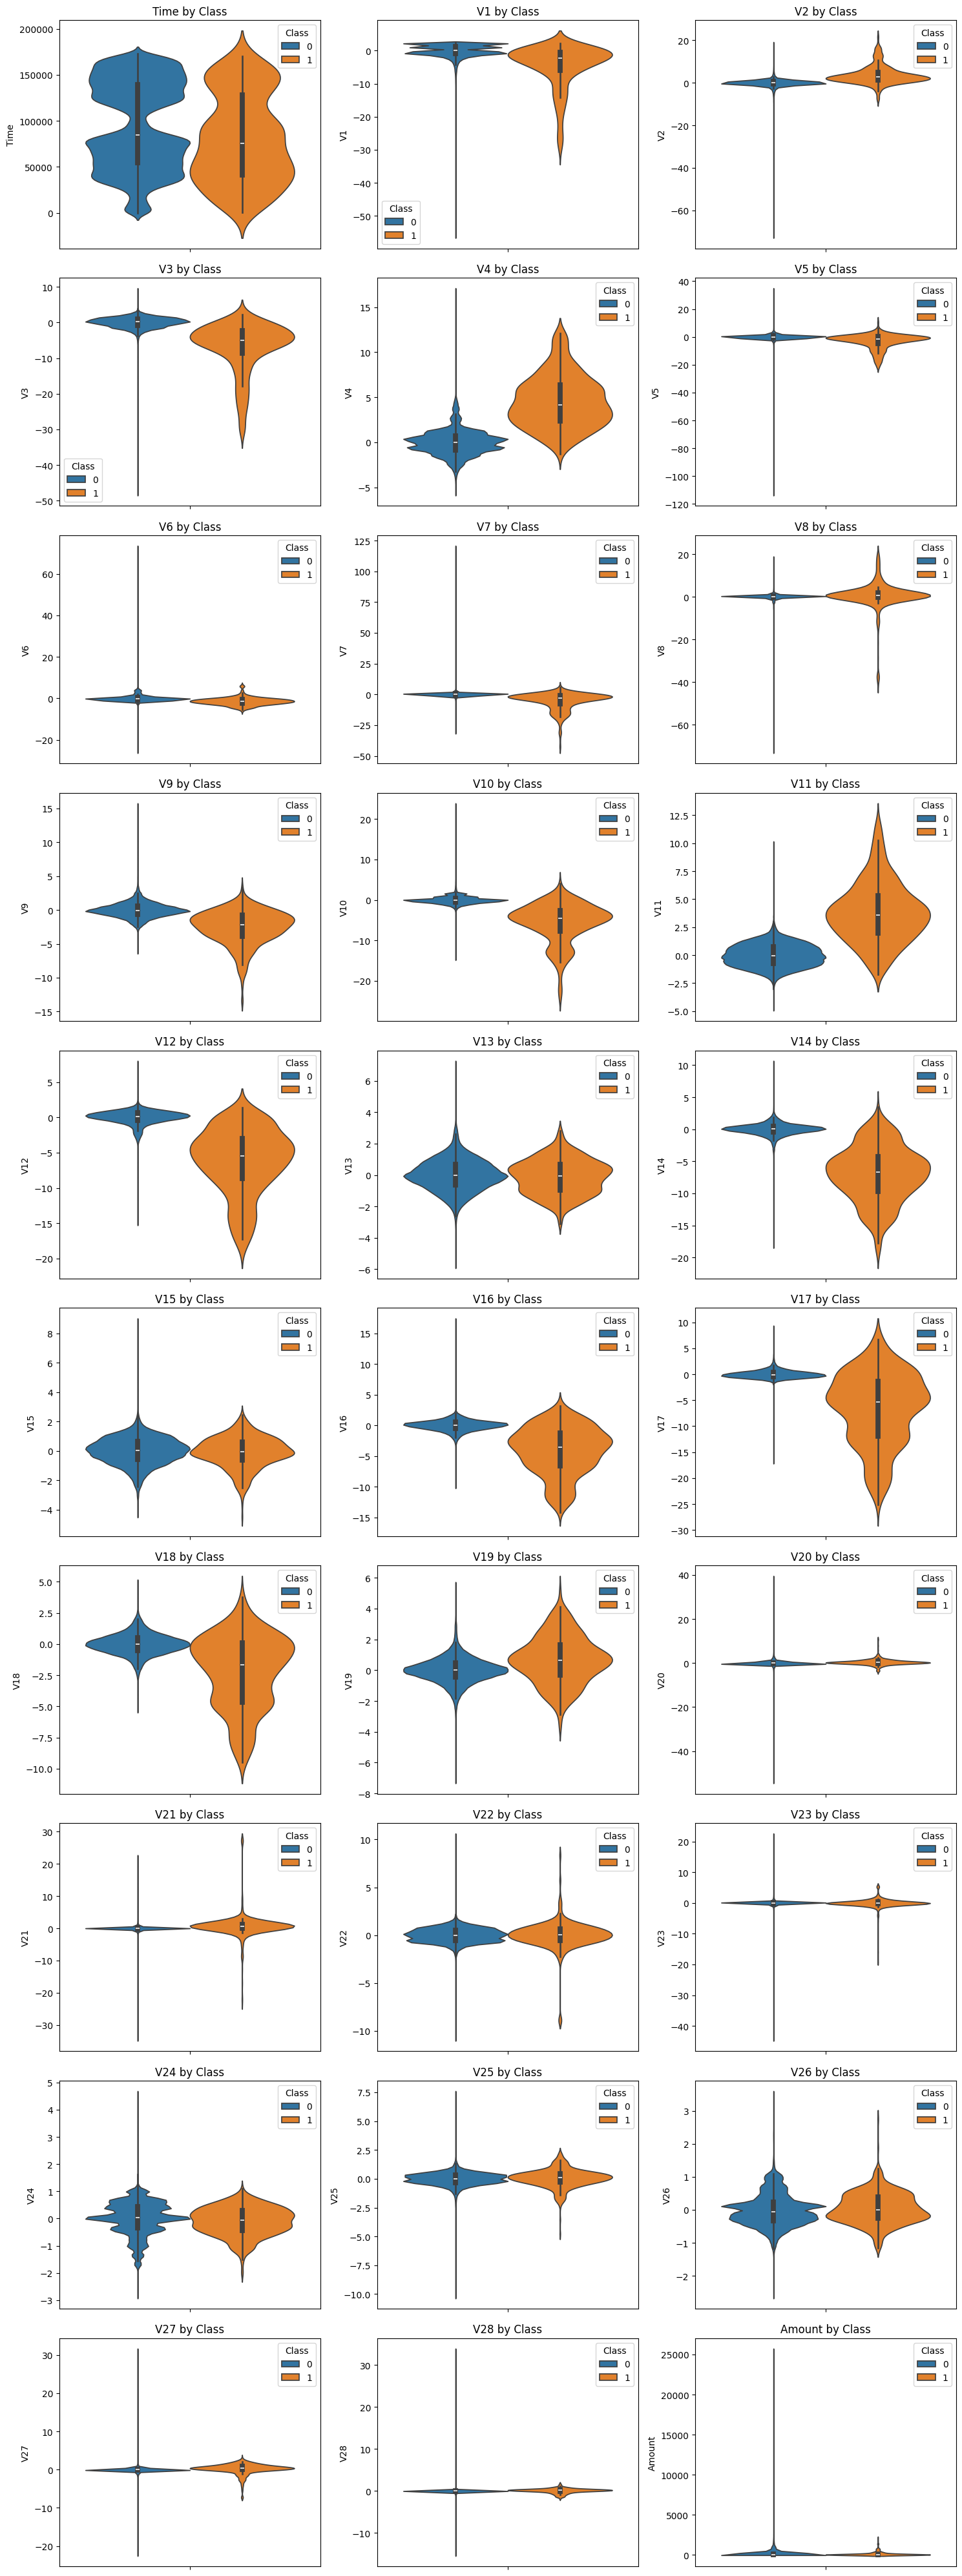

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

ncols = 3
data_cols = [col for col in df.columns if col != 'Class']
nrows = math.ceil(len(data_cols) / ncols)

plt.figure(figsize=(5 * ncols, 4 * nrows))

for i, col in enumerate(data_cols):
    plt.subplot(nrows, ncols, i + 1)
    sns.violinplot(y=col, data=df, hue=df.Class)
    plt.title(f'{col} by Class')

plt.tight_layout()
plt.show()


In [6]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

/tmp/ipykernel_511/1884894333.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_sample = df.groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=frac))


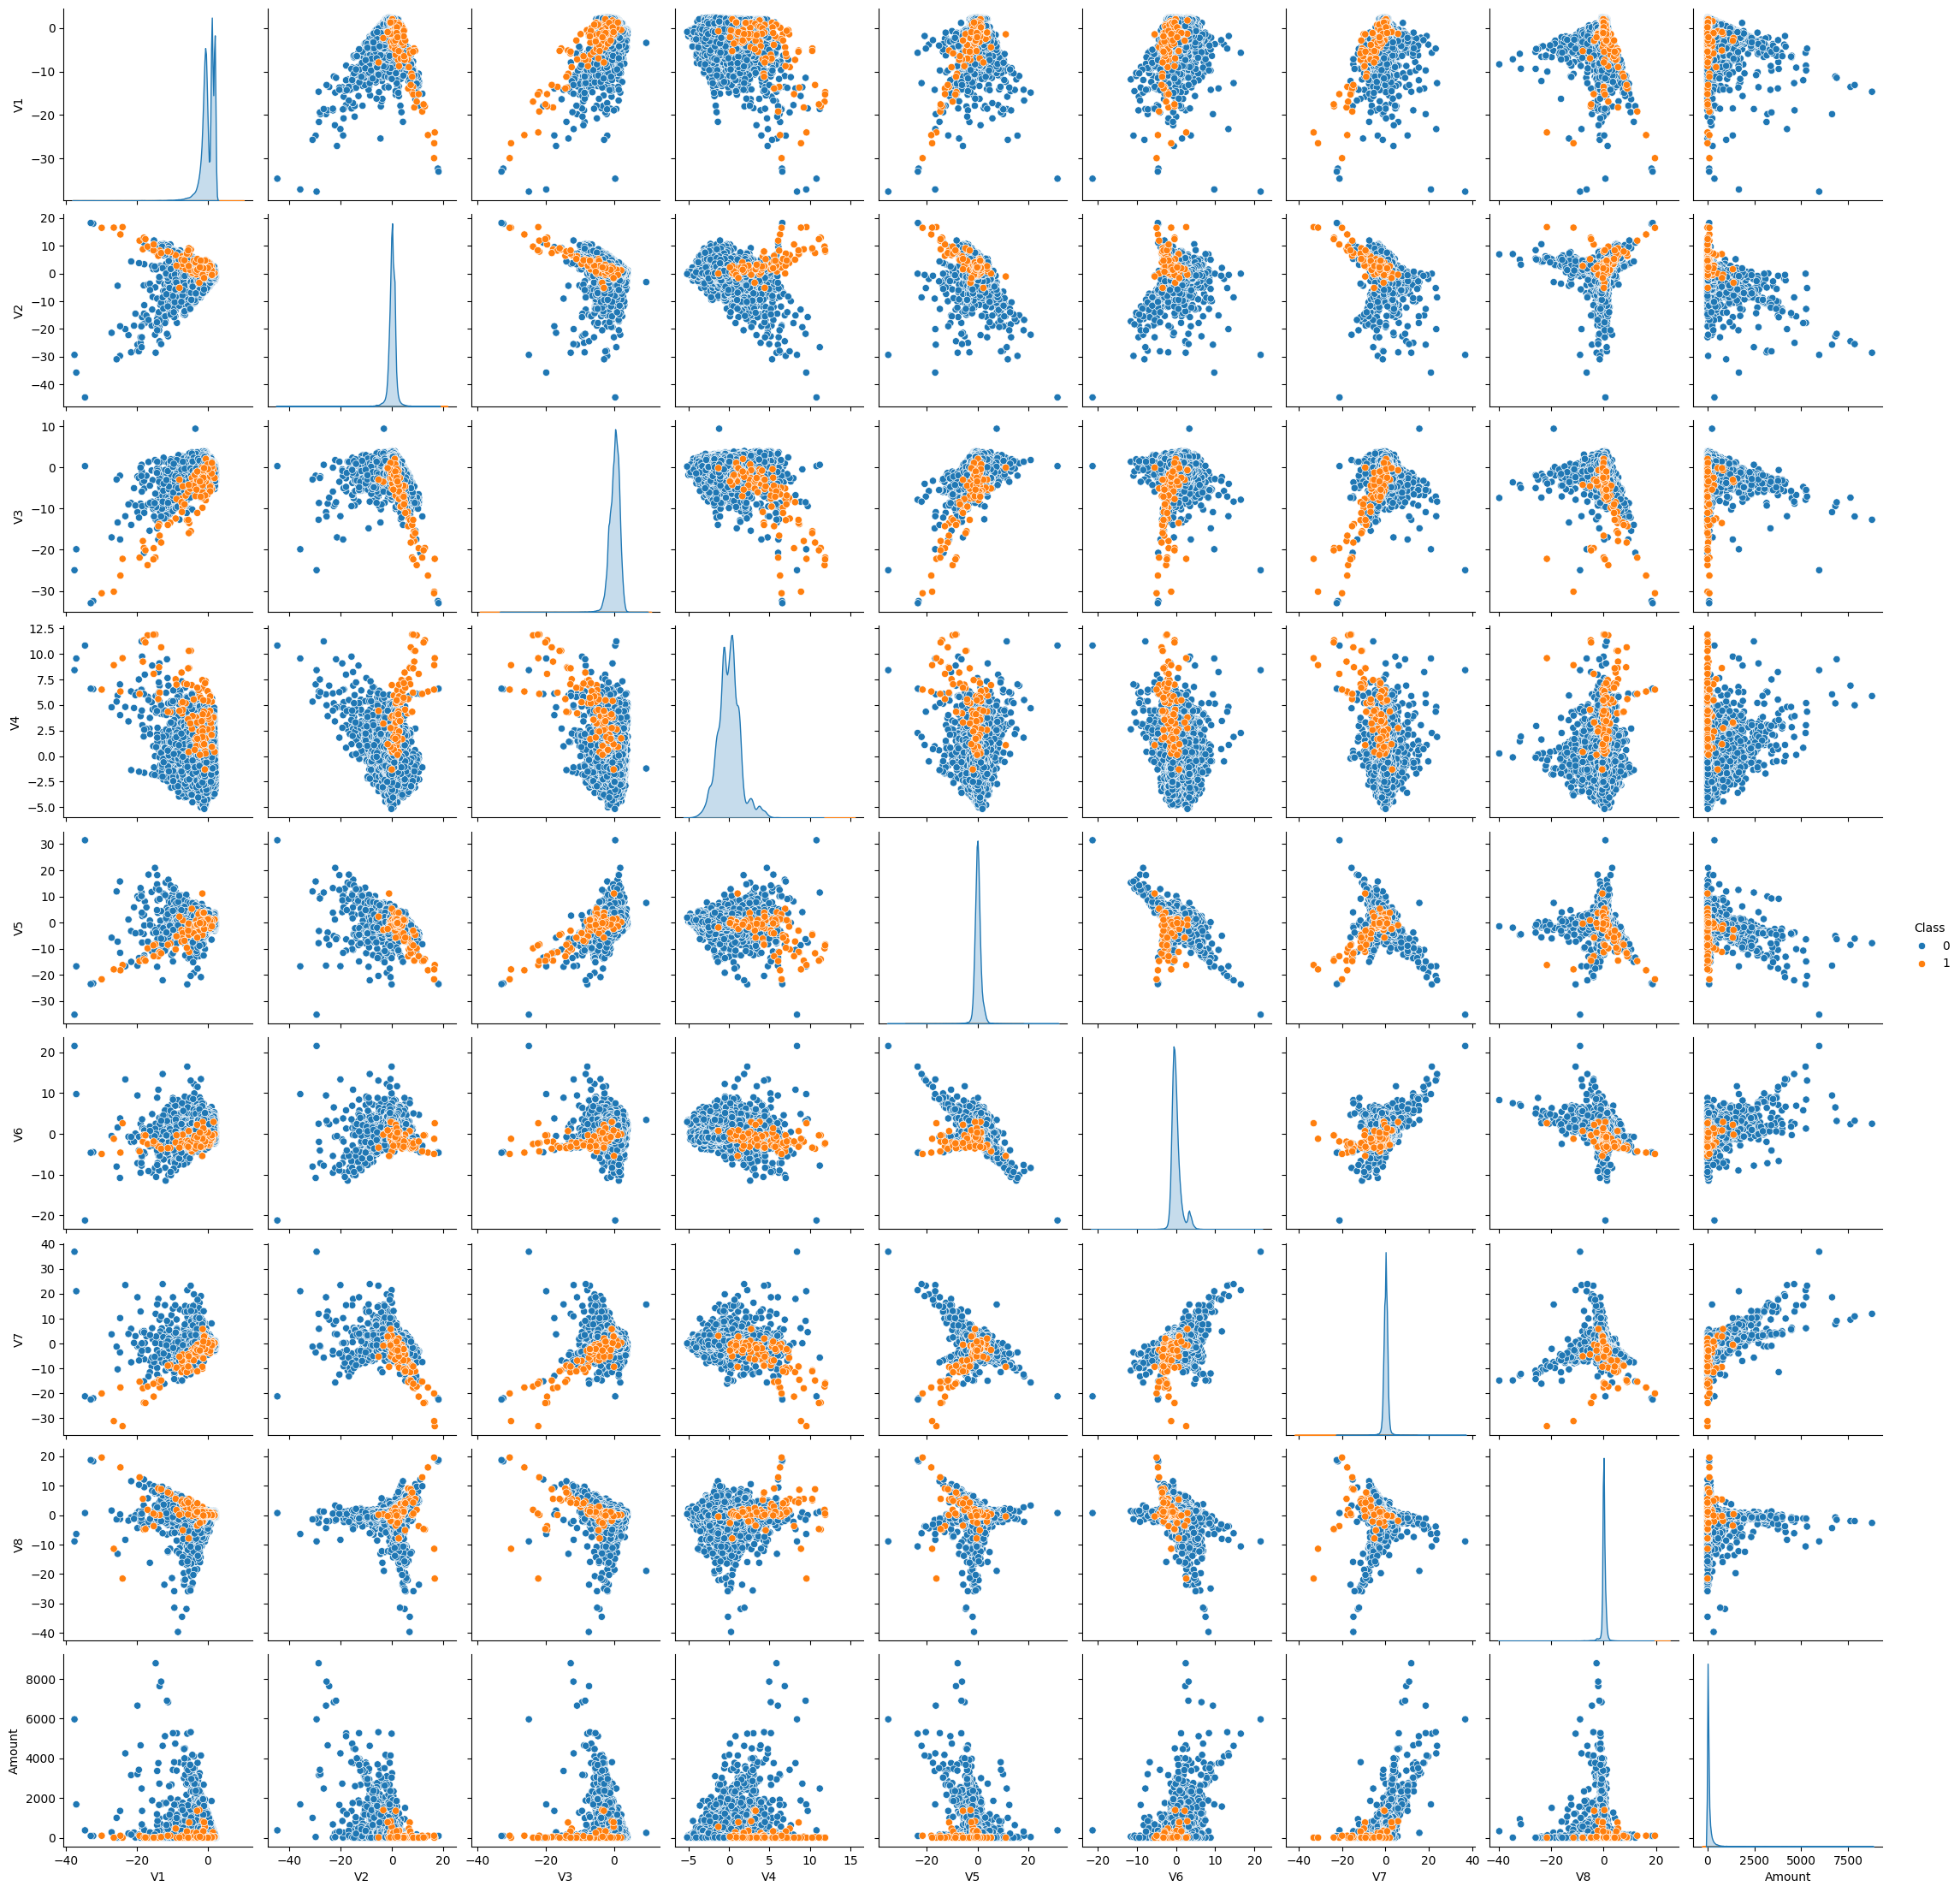

In [44]:
import pandas as pd

# Stratified sample: keep the class ratio
frac = 0.20
df_sample = df.groupby('Class', group_keys=False).apply(lambda x: x.sample(frac=frac))

# Now use df_sample for pairplot
import seaborn as sns

sns.pairplot(df_sample, hue='Class',vars=list(df.columns[1:9])+['Amount'])


In [ ]:
from scipy.stats import multivariate_normal

X = df.drop(columns=['Time','Class'])
y = df['Class']

# Split data
X_class0 = X[y == 0]
X_class1 = X[y == 1]

# Fit Gaussian to class 0
mean0 = np.mean(X_class0, axis=0)
cov0 = np.cov(X_class0, rowvar=False)
dist0 = multivariate_normal(mean=mean0, cov=cov0)

# Fit Gaussian to class 1
mean1 = np.mean(X_class1, axis=0)
cov1 = np.cov(X_class1, rowvar=False)
dist1 = multivariate_normal(mean=mean1, cov=cov1)

# Draw samples
sampled_class0 = dist0.rvs(size=100)
sampled_class1 = dist1.rvs(size=100)


In [7]:
import joblib

In [13]:
joblib.dump(mean0,'services/kafka-producer/distributions/mean0.joblib')
joblib.dump(mean1,'services/kafka-producer/distributions/mean1.joblib')
joblib.dump(cov0,'services/kafka-producer/distributions/cov0.joblib')
joblib.dump(cov1,'services/kafka-producer/distributions/cov1.joblib')


['services/kafka-producer/distributions/cov1.joblib']